<a href="https://colab.research.google.com/github/LisaATaylor/naip-classify/blob/master/SatelliteImageryClassification-TransferFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of satellite imagery tiles by transfer learning

This notebook demonstrates classification of satellite imagery tiles by transfer learning with the VGG16 network trained on ImageNet.

The workflow for obtaining and prepping the DeepSat-6 data from Kaggle is presented in [this notebook](https://github.com/LisaATaylor/naip-classify/blob/master/SatelliteImagery_DataPreparation.ipynb).

In [2]:
#save content to google drive to avoid downloading again
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from scipy.io import loadmat
data=loadmat('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat-6-full.mat')

In [0]:
#split and process data
import numpy as np
import pandas as pd

def fixaxes(inarr): #matlab format has long axis in last position, move to 1st to match tensorflow
  return np.rollaxis(inarr,3,0)

#load ndarrays from mat dictionary
trainX=fixaxes(data['train_x']) 
trainy=data['train_y'].T
testX=fixaxes(data['test_x'])
testy = data['test_y'].T
assert np.all(trainX[0,:10,0,0] == data['train_x'][:10,0,0,0])


In [0]:
# get vector of categories for interpreting outputs
anno=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/sat6annotations.csv',header=None)
anno.head()
categories=anno.loc[:,0].to_dict()
ycat=pd.DataFrame(trainy).idxmax(axis=1).map(categories)

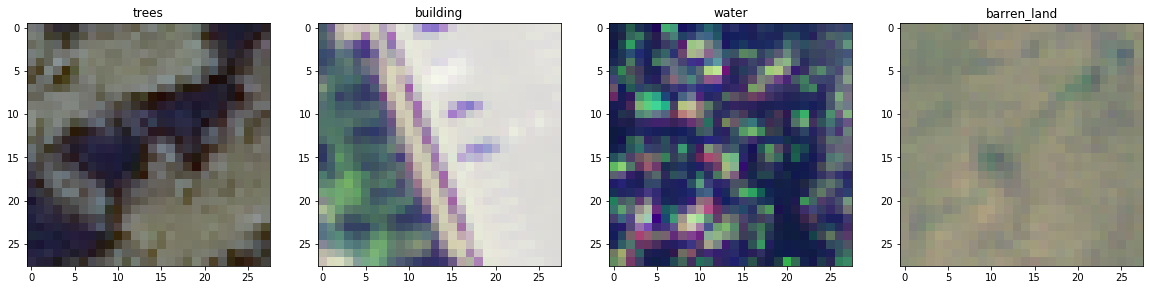

In [6]:
# look at a few tiles, visible bands
import matplotlib.pyplot as plt 
fig,axs=plt.subplots(1,4,figsize=(20,10))
axs[0].imshow(trainX[0,:,:,:3])
axs[1].imshow(trainX[6,:,:,:3])
axs[2].imshow(trainX[2,:,:,:3])
axs[3].imshow(trainX[8,:,:,:3])
axs[0].set_title(ycat.loc[0])
axs[1].set_title(ycat.loc[6])
axs[2].set_title(ycat.loc[2])
axs[3].set_title(ycat.loc[8]);

# Implement transfer learning with Keras

A classification model is implemented using the VGG16 network with a dense classifier backend.

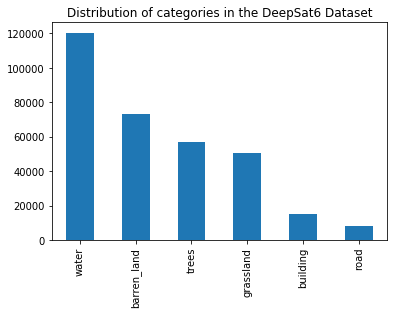

In [7]:
#look at balance between categories:  we see that the categories are not evenly distributed
ycounts=ycat.value_counts()
ycounts.plot.bar()
plt.title('Distribution of categories in the DeepSat6 Dataset');

In [0]:
#get shuffled indices for train-val split
import random
nimg=len(trainX)
ixs=list(range(nimg))
random.shuffle(ixs)
train_ix=ixs[:280000]
val_ix=ixs[280000:]

In [10]:
#create generators to feed imagery to network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow(trainX[train_ix,:,:,:3],trainy[train_ix],batch_size=512) #puts 280,000 images in train, excludes IR band
val_generator=val_datagen.flow(trainX[val_ix,:,:,:3],trainy[val_ix],batch_size=512) #puts 64,800 records in val


In [9]:
#Build CNN with transfer learning from VGG16 trained on imagenet
from tensorflow.keras import models,layers
from tensorflow.keras.applications import VGG16

cbase=VGG16(weights='imagenet',include_top=False,input_shape=(56,56,3)) 
cbase.trainable=False # freeze convolutional base

tmodel=models.Sequential()
tmodel.add(layers.UpSampling3D((2,2,1),input_shape=(28,28,3))) #upsample so image is bigger than min size for VGG16
tmodel.add(cbase)
tmodel.add(layers.Flatten())

tmodel.add(layers.Dense(512,activation='relu'))
tmodel.add(layers.Dropout(0.5))
tmodel.add(layers.Dense(6,activation='softmax'))
tmodel.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d (UpSampling3D) (None, 56, 56, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)    

In [0]:
#Compile model, load
from tensorflow.keras import optimizers
tmodel.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=0.0001),metrics=['accuracy'])

load_weights=True #load weights if not re-fitting
if load_weights:
    tmodel.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')

In [17]:
from keras.callbacks import EarlyStopping
early_stop_mon=EarlyStopping(patience=3)
if load_weights!=True:
    history=tmodel.fit_generator(train_generator,steps_per_epoch=545,epochs=30,validation_data=val_generator,validation_steps=20,callbacks=[early_stop_mon])

Epoch 1/30
545/545 [==============================] - 54s 99ms/step - loss: 0.5588 - acc: 0.7804 - val_loss: 0.3242 - val_acc: 0.8651
Epoch 2/30
545/545 [==============================] - 46s 84ms/step - loss: 0.3010 - acc: 0.8785 - val_loss: 0.2480 - val_acc: 0.9042
Epoch 3/30
545/545 [==============================] - 46s 84ms/step - loss: 0.2445 - acc: 0.9054 - val_loss: 0.2097 - val_acc: 0.9194
Epoch 4/30
545/545 [==============================] - 46s 84ms/step - loss: 0.2137 - acc: 0.9202 - val_loss: 0.1875 - val_acc: 0.9305
Epoch 5/30
545/545 [==============================] - 46s 84ms/step - loss: 0.1937 - acc: 0.9285 - val_loss: 0.1742 - val_acc: 0.9348
Epoch 6/30
545/545 [==============================] - 46s 84ms/step - loss: 0.1797 - acc: 0.9340 - val_loss: 0.1615 - val_acc: 0.9415
Epoch 7/30
545/545 [==============================] - 46s 84ms/step - loss: 0.1691 - acc: 0.9376 - val_loss: 0.1538 - val_acc: 0.9440
Epoch 8/30
545/545 [==============================] - 46s 84ms

In [0]:
save_weights=True
if save_weights:
    tmodel.save_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')
    #dump history too
    hist_df=pd.DataFrame.from_dict(history.history)
    hist_df.to_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_history.csv')


In [0]:
tmodel.load_weights('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_baseline.hdf5')


In [0]:
hist=pd.read_csv('/content/gdrive/My Drive/Springboard/Data/DeepSat6/vgg_history.csv')

# Evaluate model fit

The accuracy and loss metrics saved to the history variable over the course of model fitting are plotted to observe the improvement in model fit over each training iteration, and to check for overfitting.

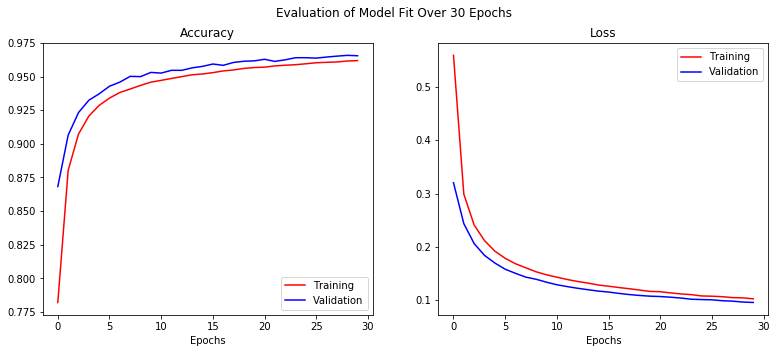

In [15]:
# Plot progression of model fit over each epoch
# adapted from Deep Learning With Python (Chollet)
h=hist#history.history
epochs = range(len(h['acc']))
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(epochs, h['acc'], 'r', label='Training')
ax[0].plot(epochs, h['val_acc'], 'b', label='Validation')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[1].plot(epochs, h['loss'], 'r', label='Training')
ax[1].plot(epochs, h['val_loss'], 'b', label='Validation')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.suptitle('Evaluation of Model Fit Over 30 Epochs');


#Evaluate held-out data

The model is applied to classify the DeepSat-6 training dataset.

In [0]:
# Look at predictions on held-out data
testX_rescaled=testX[:,:,:,:3]/255
predy=tmodel.predict(testX_rescaled)

In [0]:
#get pd Series of predicted and actual categories for test dataset
testycat=pd.DataFrame(testy).idxmax(axis=1).map(categories) #actual
testycat_pred=pd.DataFrame(predy).idxmax(axis=1).map(categories) #pred

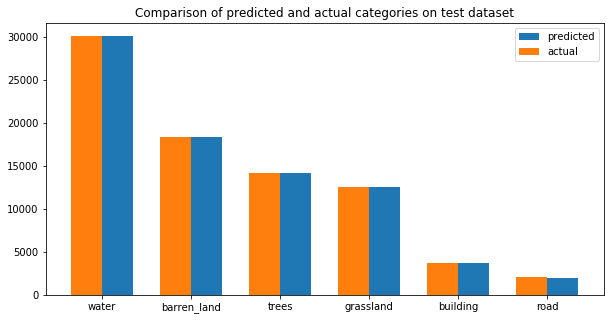

In [15]:
#Plot comparison of pred vs actual on test
pred_df=testycat_pred.value_counts()
act_df=testycat.value_counts()
fig,ax=plt.subplots(figsize=(10,5))
ind=np.arange(6)
width=0.35
pred=ax.bar(ind+width,pred_df.values,width=width,label='predicted')
act=ax.bar(ind,act_df.values,width=width,label='actual')
ax.set_xticks(ind+width/2)
ax.set_xticklabels(pred_df.index)
ax.legend()
ax.set_title('Comparison of predicted and actual categories on test dataset');

In [16]:
#get prediction errors
compare_df=pd.concat([testycat,testycat_pred],axis=1)
compare_df.columns=['actual','predicted']
compare_df=compare_df.assign(mismatch=compare_df.actual!=compare_df.predicted)
compare_df.loc[compare_df.mismatch].head()

,actual,predicted,mismatch
34,building,barren_land,True
37,barren_land,grassland,True
43,grassland,barren_land,True
84,barren_land,grassland,True
92,barren_land,grassland,True


In [37]:
#combine dfs, look at probabilities for mismatch cases
#the second highest probability is often the correct classification
pd.set_option('display.float_format', lambda x:'%.3f' % x)
pred_df=pd.concat([pd.DataFrame(predy,columns=categories.values()),compare_df],axis=1)
pred_df.loc[pred_df.mismatch==True].head(10)
#additional work: create column with rank of the actual class, prove that it is often #2 

,building,barren_land,trees,grassland,road,water,actual,predicted,mismatch
34,0.482,0.505,0.000,0.012,0.001,0.000,building,barren_land,True
37,0.000,0.151,0.022,0.827,0.000,0.000,barren_land,grassland,True
43,0.000,0.598,0.001,0.402,0.000,0.000,grassland,barren_land,True
84,0.000,0.125,0.003,0.872,0.000,0.000,barren_land,grassland,True
92,0.000,0.119,0.001,0.881,0.000,0.000,barren_land,grassland,True
106,0.101,0.891,0.000,0.000,0.007,0.000,building,barren_land,True
114,0.000,0.816,0.002,0.182,0.000,0.000,grassland,barren_land,True
152,0.763,0.000,0.000,0.000,0.237,0.000,road,building,True
203,0.000,0.113,0.059,0.828,0.000,0.000,trees,grassland,True
212,0.001,0.257,0.003,0.740,0.000,0.000,barren_land,grassland,True


In [20]:
#overall total of correct vs incorrect predictions
compare_df['mismatch'].value_counts()

False    78046
True      2954
Name: mismatch, dtype: int64

In [22]:
#accuracy on test dataset
print('Overall accuracy on test dataset: {0:.3f}'.format(1-(compare_df.mismatch.sum()/compare_df.mismatch.count())))

Overall accuracy on test dataset: 0.964


In [23]:
# Look at confusion matrix, classification report
from sklearn.metrics import classification_report,confusion_matrix
print('Classification Report:')
print(classification_report(testycat,testycat_pred))
print('Confusion Matrix:')
print(confusion_matrix(testycat,testycat_pred))
print('\nNumber of Correct Classifications:')
correct=compare_df.loc[~compare_df.mismatch].groupby(['actual','predicted']).count()
correct.columns=['Correct']
print(correct) #check order of entries along diagonal of confusion matrix

Classification Report:
              precision    recall  f1-score   support

 barren_land       0.94      0.94      0.94     18367
    building       0.95      0.96      0.95      3714
   grassland       0.91      0.91      0.91     12596
        road       0.96      0.93      0.94      2070
       trees       0.97      0.97      0.97     14185
       water       1.00      1.00      1.00     30068

    accuracy                           0.96     81000
   macro avg       0.95      0.95      0.95     81000
weighted avg       0.96      0.96      0.96     81000

Confusion Matrix:
[[17321    37   852     7   147     3]
 [   63  3561     3    76     6     5]
 [  887    14 11411     6   277     1]
 [   15   121     8  1919     4     3]
 [   85     7   293     0 13779    21]
 [    0     4     0     0     9 30055]]

Number of Correct Classifications:
                         Correct
actual      predicted           
barren_land barren_land    17321
building    building        3561
grassland   g

In [24]:
# grasslands have slightly lower recall wrt other categories 
gl_mismatch=compare_df.loc[(compare_df.mismatch)&(compare_df.actual=='grassland')]
print(gl_mismatch['predicted'].value_counts()) #roads most often misclassified as buildings
gl_mismatch['ixcopy']=gl_mismatch.index
mismatches=gl_mismatch.groupby('predicted')['ixcopy'].first()

barren_land    887
trees          277
building        14
road             6
water            1
Name: predicted, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


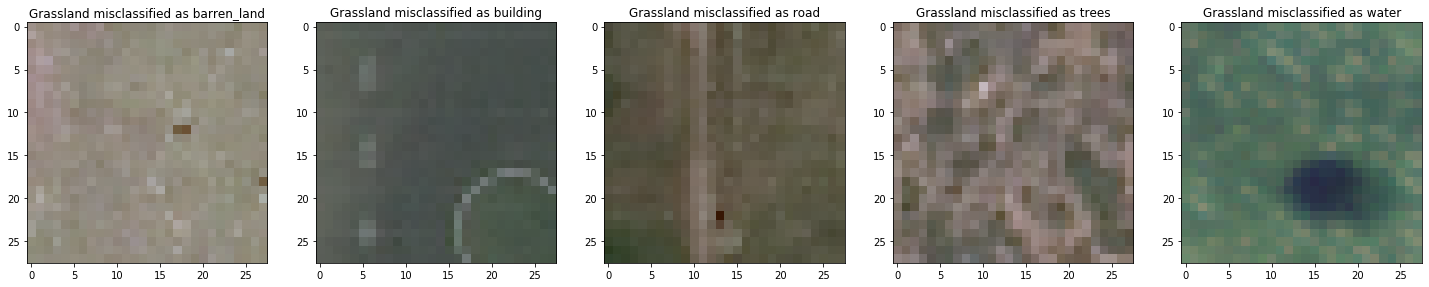

In [25]:
#view some mismatches
fig,axs=plt.subplots(1,5,figsize=(25,10))
axix=0
for i,v in mismatches.iteritems():
  axs[axix].imshow(testX[v,:,:,:3])
  axs[axix].set_title('Grassland misclassified as {}'.format(i))
  axix+=1